<a href="https://colab.research.google.com/github/forexms78/AI-05-/blob/main/%EC%8A%A4%ED%8E%A8%EB%A9%94%EC%8B%9C%EC%A7%80%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title 데이터 가져오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

url = "https://raw.githubusercontent.com/justmarkham/DAT8/master/data/sms.tsv"
df = pd.read_table(url, header=None, names=['label','message'])
df = df.reset_index(drop=True)

print('데이터셋 크기:',df.shape)
df.head()

데이터셋 크기: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# @title 데이터분할

from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [6]:
df['label'] = df['label'].map({'ham' :0, 'spam':1})

texts, Labels = df['message'].tolist(), df['label'].tolist()
train_inputs, test_inputs, train_targets, test_targets = train_test_split(
    texts,
    Labels,
    test_size=0.2,
    random_state=42
)

print(len(texts))
print(texts[0])

5572
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


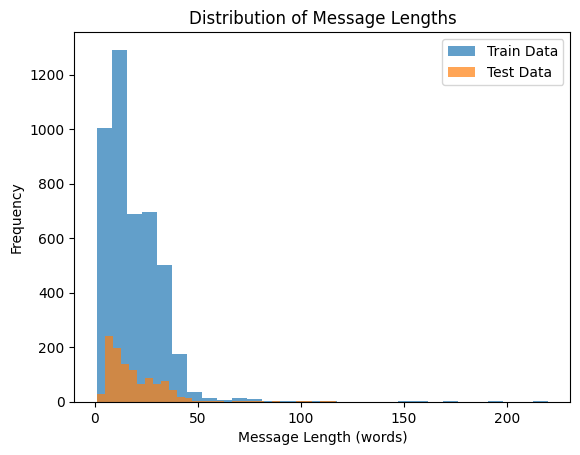

훈련 데이터 평균 길이: 18.85304016154364
훈련 데이터 최대 길이: 220
훈련 데이터 중간값: 18.85304016154364


In [7]:
# @title 메시지 길이 분포 확인 (더길게 확인하면 좋음)

train_lengths = [len(word_tokenize(msg)) for msg in train_inputs]
test_lengths = [len(word_tokenize(msg)) for msg in test_inputs]

plt.hist(train_lengths, bins=30, alpha=0.7, label='Train Data')
plt.hist(test_lengths, bins=30, alpha=0.7, label='Test Data')
plt.xlabel('Message Length (words)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Message Lengths')
plt.show()


# 평균 및 최대 길이 확인
print(f"훈련 데이터 평균 길이: {np.mean(train_lengths)}")
print(f"훈련 데이터 최대 길이: {np.max(train_lengths)}")
print(f"훈련 데이터 중간값: {np.mean(train_lengths)}")



In [8]:
# @title Word2Vec

# 단어 토큰화
train_sentences = [word_tokenize(msg) for msg in train_inputs]
test_sentences = [word_tokenize(msg) for msg in test_inputs]

In [9]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 84.2 MB/s eta 0:00:00


In [13]:
from gensim.models import Word2Vec

# Word2Vec model trian
word2vec_model = Word2Vec(
    sentences=train_sentences,
    vector_size=50,
    window=5,
    min_count=1,
    sg=1
)


word2vec_matrix = np.zeros((len(word2vec_model.wv)+1, 50))

# 값정해주기
word2idx_word2vec = {word: idx + 1 for idx, word in enumerate(
    word2vec_model.wv.index_to_key)}


for word, idx in word2idx_word2vec.items():
  word2vec_matrix[idx] = word2vec_model.wv[word]

In [14]:
word2vec_model.wv['free']

array([-1.80529669e-01,  1.31216735e-01,  1.26709625e-01, -4.72172946e-02,
       -4.56844941e-02, -1.16311505e-01,  5.33658266e-01,  7.69438505e-01,
       -2.84870237e-01, -8.58116001e-02,  2.75562480e-02, -4.24021333e-01,
        4.32866216e-01,  5.98172098e-02, -2.63119906e-01,  3.08954924e-01,
        7.02991307e-01,  2.47610033e-01, -5.93333900e-01, -2.70440638e-01,
        1.07351065e-01,  2.65993685e-01,  6.85725331e-01, -2.65964493e-02,
        5.20865560e-01,  3.86143947e-04, -1.17793761e-01,  1.45856544e-01,
       -1.51678205e-01, -5.27824052e-02,  1.58913165e-01,  1.61280468e-01,
       -2.02076994e-02, -5.53282835e-02,  1.21911064e-01,  4.22409065e-02,
        2.38789931e-01,  1.93173721e-01,  1.63190439e-01, -1.85558811e-01,
        4.86187816e-01, -3.39137644e-01,  1.42750144e-01, -9.96702686e-02,
        7.49558091e-01, -1.33364946e-01,  9.06624198e-02, -4.20186520e-01,
        1.96885294e-03,  2.91347980e-01], dtype=float32)

In [15]:
# @title 텍스트 문장을 토큰화, 정수 인코딩, 패딩/절단을 거쳐 지정된 길이(max_len)의 텐서로 변환하는 스팸 데이터셋


class WordSpamDataset(Dataset):
  def __init__(self, texts, labels, word2idx, max_len):
      self.texts = texts
      self.labels = labels
      self.word2idx = word2idx
      self.max_len = max_len

  def __len__(self):
      return len(self.texts)

  def __getitem__(self, idx):
      tokens = word_tokenize(self.texts[idx])
      encoded = [self.word2idx.get(word, 0) for word in tokens]  # OOV 단어는 0
      if len(encoded) < self.max_len:
          encoded += [0] * (self.max_len - len(encoded))
      else:
          encoded = encoded[:self.max_len]
      return torch.tensor(encoded, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

In [16]:
# @title 사전 학습된 임베딩과 LSTM을 사용하여 텍스트를 이진 분류하는 모델


class EmbeddingLSTM(nn.Module):
  def __init__(self, embedding_matrix, hidden_dim, output_dim, num_layers=2, dropout=0.5):
      super(EmbeddingLSTM, self).__init__()
      num_embeddings, embedding_dim = embedding_matrix.shape
      self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float).to(device), freeze=False)
      self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
      self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
      embedded = self.embedding(x)  # 임베딩 레이어를 통과
      _, (hidden, _) = self.lstm(embedded)  # LSTM의 출력
      output = self.fc(hidden[-1])  # 마지막 LSTM 층의 hidden state 사용
      return torch.sigmoid(output)  # sigmoid로 이진 분류

In [17]:
embedding_dim = 50
max_len = 50
hidden_dim = 128
output_dim = 1

In [19]:
# @title WordSpamDataset 및 데이터 로더
train_dataset_word2vec = WordSpamDataset(train_inputs, train_targets, word2idx_word2vec, max_len)
test_dataset_word2vec = WordSpamDataset(test_inputs, test_targets, word2idx_word2vec, max_len)

train_loader_word2vec = DataLoader(train_dataset_word2vec, batch_size=32, shuffle=True)
test_loader_word2vec = DataLoader(test_dataset_word2vec, batch_size=32, shuffle=False)